# Project 2 | Recommendation Systems - Amazon

In [1]:
# First let's load some of the basic libraries,
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import GridSearchCV

In [2]:
# load the dataset

amazon = pd.read_csv('ratings_Electronics.csv', header=None)
amazon.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:

# Shape of the dataset
amazon.shape

(7824482, 4)

### 1. Read and explore the dataset. (Rename column, plot histograms, find data characteristics)

In [4]:
amazon.columns = ['UserId', 'ProductId', 'Ratings', 'Timestamp']

In [5]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
UserId       object
ProductId    object
Ratings      float64
Timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


#### Rename Column

In [6]:
amazon.head()

,UserId,ProductId,Ratings,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [7]:
amazon.columns

Index(['UserId', 'ProductId', 'Ratings', 'Timestamp'], dtype='object')

In [8]:
# Dropping Timestamp column
if 'Timestamp' in amazon.columns :
    amazon.drop(amazon[['Timestamp']],axis=1, inplace=True)

amazon.columns

Index(['UserId', 'ProductId', 'Ratings'], dtype='object')

In [9]:
print("Mean rating : {}".format(amazon['Ratings'].mean()))
print("Mean rating standard deviation: {}".format(amazon['Ratings'].std()))

Mean rating : 4.012336791112817
Mean rating standard deviation: 1.3809098185320496


The average rating over all videos is 4.2 out of 5. We can see the overall distribution of reviews below,



Text(0, 0.5, 'count of reviews')

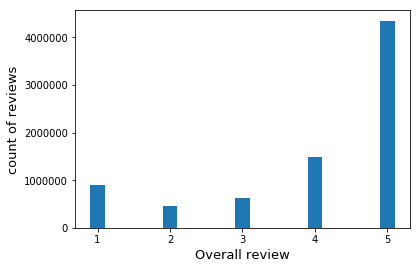

In [10]:

fig = plt.figure(figsize=(6,4))
ax  = fig.add_subplot(111)
ax.hist(amazon['Ratings'], bins=[0.9, 1.1, 1.9, 2.1, 2.9, 3.1, 3.9, 4.1, 4.9, 5.1])
ax.set_xlabel('Overall review', fontsize=13)
ax.set_ylabel('count of reviews', fontsize=13)
#ax.title('Distribution of reviews', fontsize=15)

We can also get the number of reviewers by counting the unique values of reviewerID and the product by counting the unique values of asin:

In [11]:
num_users = len(amazon['UserId'].unique())
num_items = len(amazon['ProductId'].unique())

print("Number of Users: {}".format(num_users))
print("Number of products : {}".format(num_items))
print("Number of ratings  : {}".format(len(amazon)))

Number of Users: 4201696
Number of products : 476002
Number of ratings  : 7824482


We can also find out the average number of ratings per reviewer using the groupby function with reviewerID and then counting the number of product reviews

In [12]:
avg_num_reviews = amazon.groupby('UserId')['ProductId'].count()
print("Avg Number of ratings per reviewer {}".format(avg_num_reviews.mean()))

Avg Number of ratings per reviewer 1.8622199226217222


We can also get the distribution of the mean rating of each reviewer

Text(0, 0.5, 'number of reviewers')

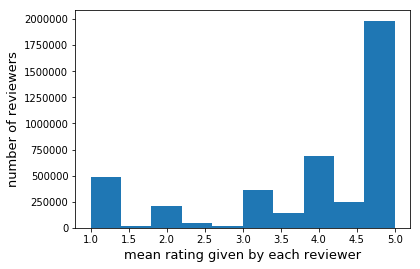

In [13]:
mean_rating_of_user = amazon.groupby('UserId').apply(lambda x: x['Ratings'].mean())

fig = plt.figure(figsize=(6,4))
ax  = fig.add_subplot(111)
ax.hist(mean_rating_of_user)
ax.set_xlabel('mean rating given by each reviewer', fontsize=13)
ax.set_ylabel('number of reviewers', fontsize=13)

 #### 1b -  Find missing values

In [17]:
amazon.isnull().sum()

UserId       0
ProductId    0
Ratings      0
dtype: int64

In [15]:
# Since above technique did not show missing values we will loop through individual column

In [18]:
amazon.isna().sum()

UserId       0
ProductId    0
Ratings      0
dtype: int64

In [19]:
amazon.isnull().any().any()

False

In [20]:
amazon.isnull().sum().sum()

0

Since above technique did not show missing values we will loop through individual column

#### 1c - Treat missing values

No need to treat the missing values as there is no missing data in the dataset imported

####  Find outliers

In [21]:
from itertools import chain

numeric_cols = amazon.select_dtypes(include=['float64', 'int64']).columns

outlier_rec = []
# For each predictors find outliers using mathematical function.
def find_outlier(df_in, col_name, verbose=False):
    q25 = df_in[col_name].quantile(0.25)
    q75 = df_in[col_name].quantile(0.75)
    iqr = q75-q25 #Interquartile range
    lower, upper  = q25-1.5*iqr, q75+1.5*iqr
    outliers_df = df_in[(df_in[col_name] < lower) | (df_in[col_name] > upper)]
    outliers_removed_df = df_in[(df_in[col_name] >= lower) & (df_in[col_name] <= upper)]
    
    if(verbose):
        print('# Number of outliers / non-outliers for column \'{}\': {} /{}'.format(
            col_name, outliers_df.shape[0], outliers_removed_df.shape[0]))
    return outliers_df.index.tolist();

for feature in numeric_cols:
    outlier_rec.append(find_outlier(amazon, feature, True))
    
outlier_rec = list(chain.from_iterable(outlier_rec))
outlier_rec = list(set(outlier_rec)) 
outlier_rec.sort()
print('# Total outliers in the dataset: {}'.format(len(outlier_rec)))
print(outlier_rec)

# Number of outliers / non-outliers for column 'Ratings': 0 /7824482
# Total outliers in the dataset: 0
[]


From above it is clear the following features have no outlier 


####  Treat outliers

No need of treating the outliers as there are no outliers exists

### 2. Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings )


In [22]:
len(amazon['UserId'].unique())

4201696

In [23]:
# Top 10 users based on rating
most_rated = amazon.groupby('UserId').size().sort_values(ascending=False)[:10]
most_rated

UserId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

In [24]:
counts = amazon['UserId'].value_counts()
amazon_df = amazon[amazon['UserId'].isin(counts[counts >= 50].index)]

In [25]:
amazon_df.head()

,UserId,ProductId,Ratings
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [26]:
amazon_df.shape

(125871, 3)

In [27]:
print('Number of users who have rated 50 or more items =', len(amazon_df))
print('Number of unique USERS in final data = ', amazon_df['UserId'].nunique())
print('Number of unique ITEMS in final data = ', amazon_df['ProductId'].nunique())

Number of users who have rated 50 or more items = 125871
Number of unique USERS in final data =  1540
Number of unique ITEMS in final data =  48190


In [28]:
final_ratings_matrix = amazon_df.pivot(index = 'UserId', columns ='ProductId', values = 'Ratings').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


In [29]:
final_ratings_matrix.tail()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserId,,,,,,,,,,,,,,,,,,,,,
AZBXKUH4AIW3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZCE11PSTCH1L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZMY6E8B52L2T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZNUHQSHZHSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZOK5STV85FBJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

UserId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
ProductId,,,,,,,,,,,,,,,,,,,,,
0594451647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Check for duplicates
duplicate_bool = amazon_df.duplicated(subset=['UserId','ProductId'], keep='first')
duplicate = amazon_df.loc[duplicate_bool == True]
duplicate

,UserId,ProductId,Ratings


No Duplicate Items are found

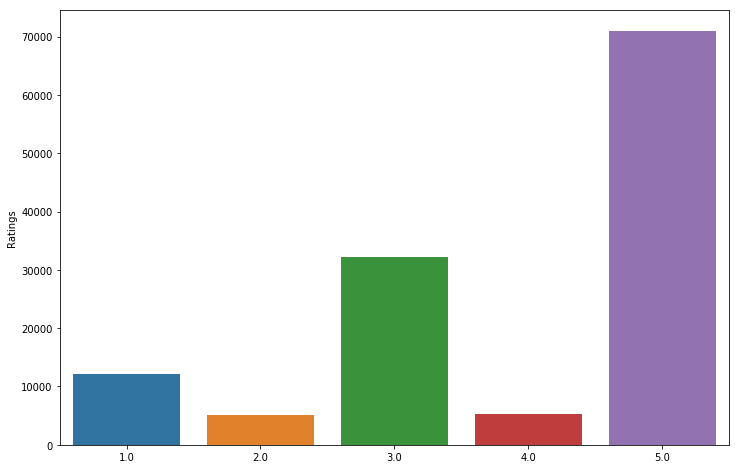

In [32]:
# Ratings split up
fig = plt.figure(figsize=(12,8))
sns.barplot(x = amazon_df['Ratings'].unique(), y= amazon_df['Ratings'].value_counts())
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019C010DFE10>]],
      dtype=object)

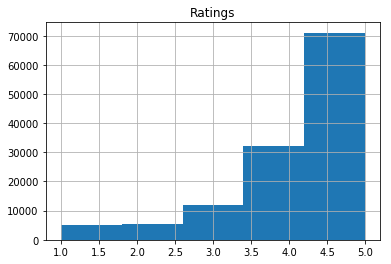

In [33]:
amazon_df.hist('Ratings',bins = 5)

### 3. Split the data randomly into train and test dataset. (For example split it in 70/30 ratio)

In [34]:
train_data, test_data = train_test_split(amazon_df, test_size = 0.30, random_state=0)
print(train_data.shape,test_data.shape)

(88109, 3) (37762, 3)


In [35]:
def shape():
    print("Test data shape: ", test_data.shape)
    print("Train data shape: ", train_data.shape)
shape()

Test data shape:  (37762, 3)
Train data shape:  (88109, 3)


In [36]:
train_data_grouped = train_data.groupby('ProductId').mean().reset_index()
train_data_sort = train_data_grouped.sort_values(['Ratings', 'ProductId'], ascending = [0,1])

### 4.  Build Popularity Recommender model.

In [37]:
# This is going to be a non - personalised model 

In [38]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'UserId': 'score'},inplace=True)
train_data_grouped.head()

,ProductId,score
0,0594451647,1
1,0594481813,1
2,0970407998,1
3,0972683275,3
4,1400501466,4


In [39]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'ProductId'], ascending = [0,1])

In [40]:
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 

In [41]:
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,ProductId,score,Rank
30847,B0088CJT4U,133,1.0
30287,B007WTAJTO,124,2.0
19647,B003ES5ZUU,122,3.0
8752,B000N99BBC,114,4.0
30555,B00829THK0,97,5.0


In [42]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['user_id'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [45]:
find_recom = [15,121,200,350]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

Here is the recommendation for the userId: 15

       user_id   ProductId  score  Rank
30847       15  B0088CJT4U    133   1.0
30287       15  B007WTAJTO    124   2.0
19647       15  B003ES5ZUU    122   3.0
8752        15  B000N99BBC    114   4.0
30555       15  B00829THK0     97   5.0


Here is the recommendation for the userId: 121

       user_id   ProductId  score  Rank
30847      121  B0088CJT4U    133   1.0
30287      121  B007WTAJTO    124   2.0
19647      121  B003ES5ZUU    122   3.0
8752       121  B000N99BBC    114   4.0
30555      121  B00829THK0     97   5.0


Here is the recommendation for the userId: 200

       user_id   ProductId  score  Rank
30847      200  B0088CJT4U    133   1.0
30287      200  B007WTAJTO    124   2.0
19647      200  B003ES5ZUU    122   3.0
8752       200  B000N99BBC    114   4.0
30555      200  B00829THK0     97   5.0


Here is the recommendation for the userId: 350

       user_id   ProductId  score  Rank
30847      350  B0088CJT4U    133   1.0
302

Since this is a popularity-based recommender model and non-personal, recommendations remain the same for all users

We predict the products based on the popularity. It is not personalized to particular user

### 5. Build Collaborative Filtering model.

Model-based Collaborative Filtering: Singular Value Decomposition, We can use KNN or SVD. We will use SVD here with Surprise package

In [46]:
from surprise import Reader, Dataset, SVD, evaluate,accuracy,GridSearch
from surprise.model_selection import GridSearchCV
from surprise.accuracy import rmse
from surprise import dump
from collections import defaultdict
from surprise.model_selection import train_test_split

In [47]:
df_CF = amazon_df
df_CF.head()

,UserId,ProductId,Ratings
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [48]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'UserId', columns ='ProductId', values = 'Ratings').fillna(0)
print(pivot_df.shape)
pivot_df.head()

(1540, 48190)


ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:

pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
UserId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [50]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SVD Method

SVD is best to apply on a large sparse matrix

In [51]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 50)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

SVD is useful in many tasks, such as data compression, noise reduction similar to Principal Component Analysis and Latent Semantic Indexing (LSI), used in document retrieval and word similarity in Text mining

In [52]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,-0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,-0.061477,0.001214,-0.123433,0.028490,0.016109,0.002855,-0.174568,0.011367,-0.012997
1,0.002286,-0.010898,-0.000724,0.130259,0.007506,-0.003350,0.063711,-0.000674,0.016111,-0.002433,...,-0.000038,0.013766,0.001473,0.025588,-0.042103,0.004251,0.002177,-0.024362,-0.014765,0.038570
2,-0.001655,-0.002675,-0.007355,0.007264,0.005152,-0.003986,-0.003480,0.006961,-0.006606,-0.002719,...,-0.001708,-0.051040,0.000325,-0.054867,0.017870,-0.004996,-0.002426,0.083928,-0.112205,0.005964
3,0.001856,0.011019,-0.005910,-0.014134,0.000179,0.001877,-0.005391,-0.001709,0.004968,0.001402,...,0.000582,-0.009326,-0.000465,-0.048315,0.023302,0.006790,0.003380,0.005460,-0.015263,-0.025996
4,0.001115,-0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,-0.019347,-0.012749,0.001026,0.001364,-0.020580,0.011828,0.012770


In [53]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [55]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 15
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 15):

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          0.335415
B000QUUFRW                  0.0          0.281862
B002WE6D44                  0.0          0.228786
B00004ZCJE                  0.0          0.193438
B001XURP7W                  0.0          0.170882


In [54]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 121
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 121):

                   user_ratings  user_predictions
Recommended Items                                
B000LRMS66                  0.0          0.543927
B002WE4HE2                  0.0          0.423175
B000KO0GY6                  0.0          0.416801
B001XURP7W                  0.0          0.356788
B005HMKKH4                  0.0          0.352138


In [53]:
userID = 250
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 250):

                   user_ratings  user_predictions
Recommended Items                                
B001TH7GUU                  0.0          1.538982
B007WTAJTO                  0.0          0.901690
B002V88HFE                  0.0          0.841669
B005CLPP84                  0.0          0.791949
B005FYNSPK                  0.0          0.785244


In [57]:
userID = 300
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 300):

                   user_ratings  user_predictions
Recommended Items                                
B004CLYEDC                  0.0          0.049390
B003UE52ME                  0.0          0.044529
B000EOPQ7E                  0.0          0.038008
B004CLYEFK                  0.0          0.036443
B005FDXZJU                  0.0          0.034459


### 6. Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

In [58]:
# Actual ratings given by the users
final_ratings_matrix.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

ProductId
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [60]:
# Predicted ratings 
preds_df.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,-0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,-0.061477,0.001214,-0.123433,0.028490,0.016109,0.002855,-0.174568,0.011367,-0.012997
1,0.002286,-0.010898,-0.000724,0.130259,0.007506,-0.003350,0.063711,-0.000674,0.016111,-0.002433,...,-0.000038,0.013766,0.001473,0.025588,-0.042103,0.004251,0.002177,-0.024362,-0.014765,0.038570
2,-0.001655,-0.002675,-0.007355,0.007264,0.005152,-0.003986,-0.003480,0.006961,-0.006606,-0.002719,...,-0.001708,-0.051040,0.000325,-0.054867,0.017870,-0.004996,-0.002426,0.083928,-0.112205,0.005964
3,0.001856,0.011019,-0.005910,-0.014134,0.000179,0.001877,-0.005391,-0.001709,0.004968,0.001402,...,0.000582,-0.009326,-0.000465,-0.048315,0.023302,0.006790,0.003380,0.005460,-0.015263,-0.025996
4,0.001115,-0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,-0.019347,-0.012749,0.001026,0.001364,-0.020580,0.011828,0.012770


In [61]:
# Average PREDICTED rating for each item
preds_df.mean().head()

ProductId
0594451647    0.001953
0594481813    0.002875
0970407998    0.003355
0972683275    0.010343
1400501466    0.004871
dtype: float64

In [62]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
ProductId,,,
0594451647,0.003247,0.001953,0
0594481813,0.001948,0.002875,1
0970407998,0.003247,0.003355,2
0972683275,0.012338,0.010343,3
1400501466,0.012987,0.004871,4


In [63]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.00275 



### 7. Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits,we will recommend 5 new products.

In [67]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 200
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 200):

                   user_ratings  user_predictions
Recommended Items                                
B008X9Z8NE                  0.0          1.141688
B0079UAT0A                  0.0          1.101302
B008X9Z528                  0.0          1.072300
B004CLYEFK                  0.0          1.025798
B008X9Z7N0                  0.0          1.002051


In [65]:
userID = 350
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 350):

                   user_ratings  user_predictions
Recommended Items                                
B001TH7GUU                  0.0          0.442695
B003ES5ZUU                  0.0          0.347548
B000N99BBC                  0.0          0.310239
B007WTAJTO                  0.0          0.304464
B001CIREXA                  0.0          0.287759


### 8. Summarise your insights.

Model-based Collaborative Filtering is a personalised recommended system, the recommendations are based on the past behaviour of the user and it is not dependent on any additional information.

The Popularity-based recommended system is non-personalised and the recommendations are based on frequency counts, which may be not suitable to the all users. You can see the difference above for the user id 121 & 200, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history